# Masking PAD symbols in attention weights

Our example dataset is consists of 4 samples of various length, 10 being the longest one.

## Visualization

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def softmax(mtx):
    """Compute softmax on 2D tensor alon the second dimension"""
    e = np.exp(mtx)
    s = np.sum(e, axis=1)
    return e / s[:, None]
    
X = np.arange(18, dtype=np.float64).reshape(3, 6)
X[2, 4] = float("-inf")
s = softmax(X)
s

array([[0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.23312201,
        0.63369132],
       [0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.23312201,
        0.63369132],
       [0.00556774, 0.01513469, 0.04114036, 0.11183108, 0.        ,
        0.82632613]])

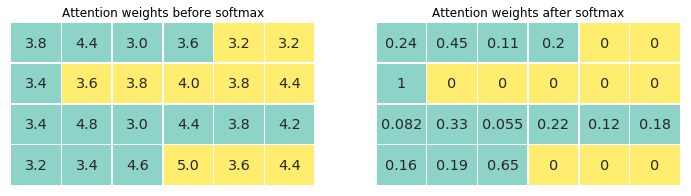

In [3]:
np.random.seed(1)
sample_no, sample_len = (4, 6)
data = np.zeros((sample_no, sample_len), dtype=np.float32)
seq_len = np.array([4, 1, 6, 3], dtype=np.int32)
mask = np.arange(sample_len) < seq_len[:, None]
data[~mask] = 1

annot = np.random.random(data.shape).round(1) * 2 + 3

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 3))
sns.heatmap(data, ax=ax[0], cbar=False, linewidths=.5, cmap='Set3',
            annot=annot, xticklabels=False, yticklabels=False,
            annot_kws={'fontsize': 'x-large'}, fmt=".2")
ax[0].set_title("Attention weights before softmax")
ax[1].set_title("Attention weights after softmax")

annot[~mask] = float("-inf")
annot = softmax(annot)

sns.heatmap(data, ax=ax[1], cbar=False, linewidths=.5, cmap='Set3',
            annot=annot, xticklabels=False, yticklabels=False,
            annot_kws={'fontsize': 'x-large'})

fig.savefig("softmax_before_after.png", dpi=100)

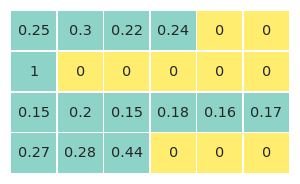

In [4]:
fig, ax = plt.subplots(1, figsize=(5, 3))
annot[~mask] = float("-inf")
annot = softmax(annot)

sns.heatmap(data, ax=ax, cbar=False, linewidths=.5, cmap='Set3',
            annot=annot, xticklabels=False, yticklabels=False,
            annot_kws={'fontsize': 'x-large'})

fig.savefig("masked_attention_final.png", dpi=100)

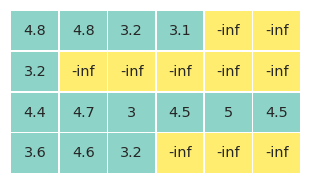

In [5]:
annot = np.random.random(data.shape).round(2) * 2 + 3
annot[~mask] = float("-inf")

fig, ax = plt.subplots(1, figsize=(5.2, 3))
sns.heatmap(data, ax=ax, cbar=False, linewidths=.5, cmap='Set3',
            annot=annot, xticklabels=False, yticklabels=False,
            annot_kws={'fontsize': 'x-large'})
fig.savefig("masked_attention_inf.png", dpi=100)

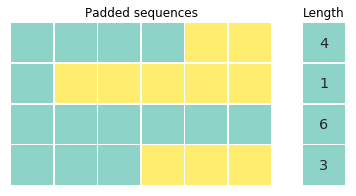

In [6]:
sample_no, sample_len = (4, 6)
data = np.zeros((sample_no, sample_len), dtype=np.float32)
seq_len = np.array([4, 1, 6, 3], dtype=np.int32)
mask = np.arange(sample_len) < seq_len[:, None]
data[~mask] = 1

fig, ax = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw = {'width_ratios':[6, 1]})
sns.heatmap(data, ax=ax[0], cbar=False, linewidths=.5, cmap='Set3',
            xticklabels=False, yticklabels=False,)
ax[0].set_title("Padded sequences")

sns.heatmap(np.zeros((sample_no, 1)), annot=seq_len[:, None], ax=ax[1], cmap='Set3',
            cbar=False, linewidths=.5, annot_kws={'fontsize': 'x-large'},
            xticklabels=False, yticklabels=False,)

ax[1].set_title("Length")

fig.savefig("padded_sequence.png", dpi=100)

# Masked assignment

In [7]:
X = torch.arange(12).view(4, 3)
mask = torch.zeros((4, 3), dtype=torch.uint8)  # same as dtype=torch.ByteTensor
mask[0, 0] = 1
mask[1, 1] = 1
mask[3, 2] = 1
X[mask] = 100
print(X)

tensor([[100,   1,   2],
        [  3, 100,   5],
        [  6,   7,   8],
        [  9,  10, 100]])


In [8]:
X = torch.arange(12).view(4, 3)
X[~mask] = 100
print(X)

tensor([[  0, 100, 100],
        [100,   4, 100],
        [100, 100, 100],
        [100, 100,  11]])


## Let's create a mask for the 'valid' symbols

In [9]:
X = np.random.random((4, 6)).round(1) * 2 + 3
X = torch.from_numpy(X)
X_len = torch.LongTensor([4, 1, 6, 3]) 
maxlen = X.size(1)

In [10]:
%%timeit
mask = torch.arange(maxlen)[None, :] < X_len[:, None]

16.5 µs ± 496 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
%%timeit
idx = torch.arange(maxlen).unsqueeze(0).expand(X.size())
len_expanded = X_len.unsqueeze(1).expand(X.size())
mask = idx < len_expanded

20 µs ± 871 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
mask

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
        [0, 0, 1]], dtype=torch.uint8)

## Now we want to compute softmax on the 'valid' elements

Setting the values to zero before calling softmax results in nonzero probabilities since `exp(0)=1`: 

In [13]:
X = np.random.random((4, 6)).round(1) * 2 + 3
X = torch.from_numpy(X)
maxlen = X.size(1)
mask = torch.arange(maxlen)[None, :] < X_len[:, None]

X[~mask] = float('-inf')
print(torch.softmax(X, dim=1))

tensor([[0.1235, 0.5007, 0.2250, 0.1508, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0733, 0.2433, 0.0895, 0.2972, 0.1631, 0.1335],
        [0.1286, 0.6370, 0.2344, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)


In practice, a large negative number might work:

In [14]:
X = np.random.random((4, 6)).round(1) * 2 + 3
X = torch.from_numpy(X)
maxlen = X.size(1)
mask = torch.arange(maxlen)[None, :] < X_len[:, None]

X[~mask] = -10000
print(torch.softmax(X, dim=1))

tensor([[0.4419, 0.2425, 0.0730, 0.2425, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1671, 0.3045, 0.0615, 0.0503, 0.2493, 0.1671],
        [0.1098, 0.4451, 0.4451, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
